# Tasks to do in this program

- import necessary packages
- get data
- show random picture
- split the data test and train
- take the image data and normalize the data
- label encode
- define CNN
- prediction and actual accuracy
- Confusion matrix visulization

In [31]:
import warnings
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras.layers
from keras.utils.np_utils import to_categorical
from keras import Sequential
from keras.regularizers import L2
from mlxtend.evaluate import confusion_matrix,scoring
from mlxtend.plotting import plot_confusion_matrix
from skimage.transform import resize
from vis.visualization import visualize_cam,visualize_saliency,overlay
from vis.utils import utils
import keras.callbacks

In [2]:
#get data
label_data=pd.read_csv('E:\python\python_projects\deepfaceTensorflow\DeepLearning\CNN\datasets\cifar10Labels.csv',index_col=0)


In [3]:
ytrain,ytest=train_test_split(label_data['label'],test_size=0.2,random_state=42)
print(ytrain)

id
39088     frog
30894     bird
45279      dog
16399     frog
13654      cat
         ...  
11285    horse
44733     bird
38159     ship
861       ship
15796     ship
Name: label, Length: 40000, dtype: object


In [4]:
temp=[]
for i in ytrain.index:
    img_path=os.path.join('E:\python\python_projects\deepfaceTensorflow\DeepLearning\CNN\datasets\cifar10',f'{i}.png')
    img=np.array(imageio.imread(img_path)).astype('float32')
    temp.append(img)

xtrain=np.stack(temp)
print(xtrain.shape)
temp=[]
for i in ytest.index:
    img_path=os.path.join('E:\python\python_projects\deepfaceTensorflow\DeepLearning\CNN\datasets\cifar10',f'{i}.png')
    img=np.array(imageio.imread(img_path)).astype('float32')
    temp.append(img)
xtest=np.stack(temp)
print(xtest.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
xtrain=xtrain/255.
xtest=xtest/255.


#encode
lb=LabelEncoder()

ytrain=lb.fit_transform(ytrain)
ytrain_norm=to_categorical(ytrain)

#
# print(ytest)
ytest=lb.fit_transform(ytest)
ytest_norm=to_categorical(ytest)
print(ytrain_norm.shape,ytest_norm.shape)


(40000, 10) (10000, 10)


In [16]:
#build CNN network
num_classes=10

model=Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same',activation='relu',kernel_regularizer=L2(0.01),input_shape=(32,32,3),name='conv1'),
    keras.layers.Normalization(name='norm1'),
    keras.layers.MaxPool2D(pool_size=(2,2),name='maxpool1'),
    keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same',activation='relu',kernel_regularizer=L2(0.01),input_shape=(32,32,3),name='conv2'),
    keras.layers.Normalization(name='norm2'),
    keras.layers.MaxPool2D(pool_size=(2,2),name='maxpool2'),
    keras.layers.Flatten(name='flat'),
    keras.layers.Dense(num_classes,activation='softmax',name='pred_values'),
])

model.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(),metrics=['accuracy'])
cpfile=r'cifar10.hdf5'
cb_checkpoint=keras.callbacks.ModelCheckpoint(cpfile,monitor='val_acc',verbose=1,save_best_only=True,mode='max')
model.summary()
model.fit(xtrain,ytrain_norm,epochs=5,callbacks=[cb_checkpoint],validation_split=0.2,)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 norm1 (Normalization)       (None, 32, 32, 32)        65        
                                                                 
 maxpool1 (MaxPooling2D)     (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 norm2 (Normalization)       (None, 16, 16, 64)        129       
                                                                 
 maxpool2 (MaxPooling2D)     (None, 8, 8, 64)          0         
                                                                 
 flat (Flatten)              (None, 4096)             

In [8]:
# prediction
y_train_pred=model.predict(xtrain)
y_train_pred=np.argmax(y_train_pred,axis=1)
print(y_train_pred)

y_test_pred=model.predict(xtest)
y_test_pred=np.argmax(y_test_pred,axis=1)
print(y_test_pred)

1250/1250 [==============================] - 2s 1ms/step
[6 2 5 ... 8 8 8]
313/313 [==============================] - 1s 2ms/step
[3 8 0 ... 8 4 4]


In [9]:

train_acc=scoring(lb.inverse_transform(y_train_pred),lb.inverse_transform(ytrain))
test_acc=scoring(lb.inverse_transform(y_test_pred),lb.inverse_transform(ytest))
print(f'train accuracy: {train_acc} test accuracy: {test_acc}')

train accuracy: 0.365 test accuracy: 0.3832


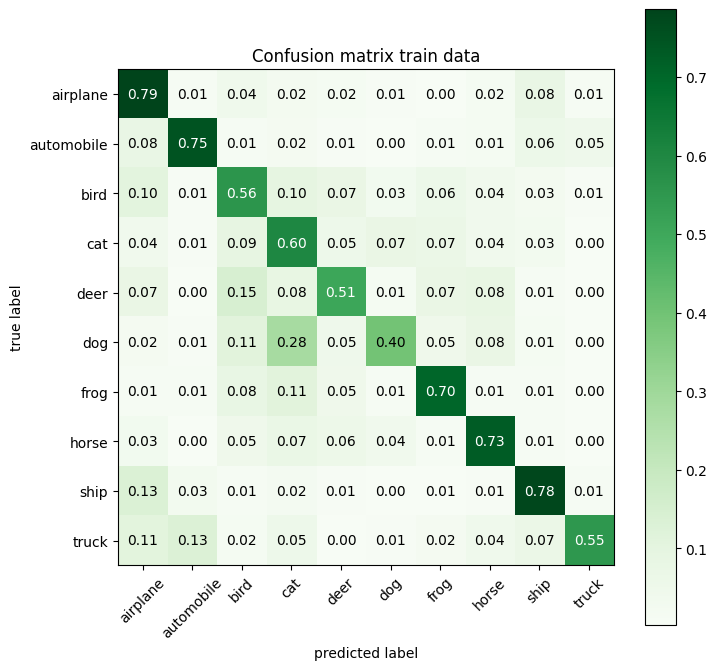

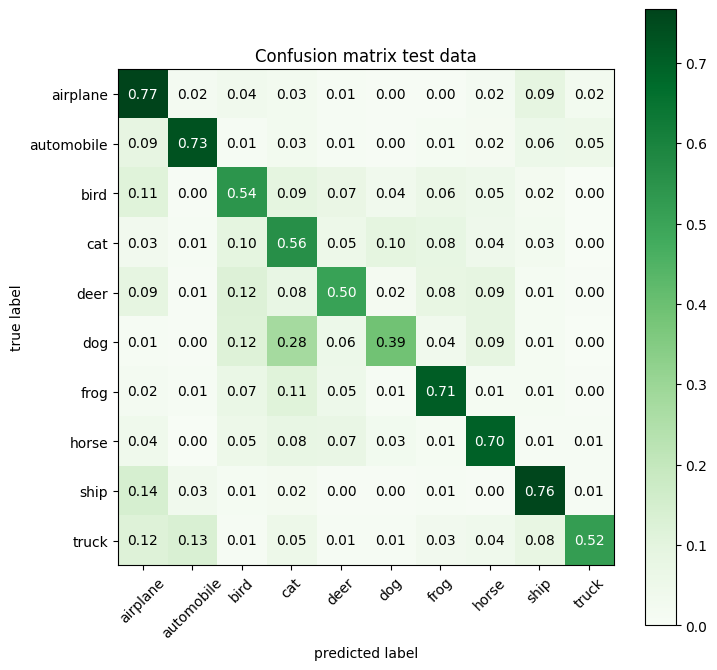

In [17]:
def plot_cm(cm,text):
    class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    plot_confusion_matrix(conf_mat=cm,figsize=(8,8),colorbar=True,cmap='Greens',show_absolute=False,show_normed=True)
    tick_marks=np.arange(len(class_names))
    plt.xticks(tick_marks,class_names,rotation=45)
    plt.yticks(tick_marks,class_names)
    plt.title(text)
    plt.show()


    return

train_cm=confusion_matrix(lb.inverse_transform(ytrain),lb.inverse_transform(y_train_pred))
test_cm=confusion_matrix(lb.inverse_transform(ytest),lb.inverse_transform(y_test_pred))
plot_cm(train_cm,'Confusion matrix train data')
plot_cm(test_cm,'Confusion matrix test data')


['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


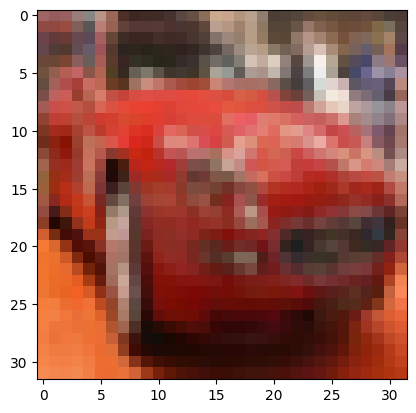

1/1 [==============================] - 7s 7s/step


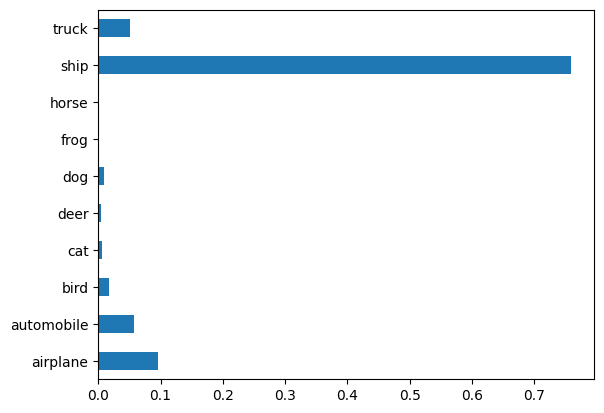

In [18]:
#dense layer visualization

#index of categories for our model
classes=lb.inverse_transform(np.arange(10))
print(classes)
img_path=os.path.join('E:\python\python_projects\deepfaceTensorflow\DeepLearning\CNN\datasets\cifar10',f'{6}.png')
ship_img = utils.load_img(img_path)
plt.imshow(ship_img)
plt.show()


#predicting the probility for each of the class for the image
ship_prob=model.predict(xtest[6:7]).ravel().copy()
pd.Series(ship_prob,index=classes).plot.barh()
plt.show()

In [22]:
# to visualize the activation over final dense layer output we need to switch the softmax activation to linear since the gradient of the output node 

layer_idx=utils.find_layer_idx(model,'pred_values')
model.layers[layer_idx].activation=keras.activations.linear
model=utils.apply_modifications(model)

# salient map
- which part the model focuses on to get the prediction


In [33]:
# Replace this line
with tf.get_default_graph().gradient_override_map({'Relu': backprop_modifier}):

# With this line
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
# Apply your modification here

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

RuntimeError: The Session graph is empty. Add operations to the graph before calling run().

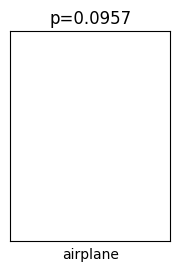

In [47]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
with tf.Session() as sess:
    # Load your model here if it's not already loaded
    # You may need to define your model and operations here
#     model.fit(xtrain,ytrain_norm,epochs=5,callbacks=[cb_checkpoint],validation_split=0.2,)

    
    plt.figure(figsize=(12,6))
    for i in range(len(classes)):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(classes[i])
        plt.title('p='+str(np.round(ship_prob[i],4)))
        grads=visualize_saliency(model, layer_idx,filter_indices=i,seed_input=ship_img,backprop_modifier='guided')
        plt.imshow(grads,cmap='jet')
    plt.show()    

In [42]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
print('tensorflow {}'.format(tf.__version__))
print("keras {}".format(keras.__version__))

tensorflow 2.10.1
keras 2.10.0


RuntimeError: The Session graph is empty. Add operations to the graph before calling run().

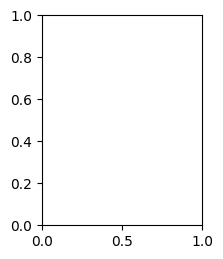

In [49]:
plt.figure(figsize=(12,6))
for i in range(len(classes)):
    plt.subplot(2, 5, i + 1)
    cam_grads = visualize_cam(model, layer_idx, filter_indices=i, seed_input=ship_img, backprop_modifier='guided',
                             penultimate_layer_idx=utils.find_layer_idx(model, 'norm2'))# batch_normalization_14
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes[i])
    plt.title('p=' + str(np.round(ship_prob[i], 4)))
    plt.imshow(overlay(cam_grads, ship_img, alpha=0.3))
plt.show()